# Power Dissipation Index (PDI) Analysis

## Definitions 

PDI is an index that represents the destructive power of a storm combining together, intensity, duration, and frequency.

References: [Emanuel, 2005](ftp://texmex.mit.edu/pub/emanuel/PAPERS/NATURE03906.pdf) and [Emanuel, 2007](ftp://texmex.mit.edu/pub/emanuel/PAPERS/Factors.pdf)

In the references, Kerry Emanuel defines the index as:

$$PDI\equiv\int_0^{\tau}V^3_{max}dt~,$$

where $V_{max}$ is the maximum sustained wind speed, and $\tau$ is the lifetime of the storm event.



## The PDI Dataset

We're gonna use the PDI calculated by [National Oceanic & Atmospheric Administration (NOAA)](https://www.noaa.gov) which data is avaible at [Our World in Data](https://ourworldindata.org/grapher/cyclone-power-dissipation-index). It covers the North Atlantic, Caribbean and Gulf of Mexico storms.

The data has been smoothed through a five-year weighted average plotted at the center, in order to remove interannual variability. We're gonna o the same smooth with our climate dataset of Atlantic MDR.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
# from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import scipy.stats as stats
from math import *
sns.set()
%matplotlib inline

In [2]:
raw_pdi = pd.read_csv('Datasets/cyclone-power-dissipation-index.csv')
raw_pdi

,Entity,Code,Year,"Cyclone Power Dissipation Index (PDI) (HUDRAT, NOAA)"
0,North Atlantic,NaN,1951,2.7846
1,North Atlantic,NaN,1952,2.3445
2,North Atlantic,NaN,1953,2.2639
3,North Atlantic,NaN,1954,2.4730
4,North Atlantic,NaN,1955,2.4041
...,...,...,...,...
58,North Atlantic,NaN,2009,3.0860
59,North Atlantic,NaN,2010,3.2155
60,North Atlantic,NaN,2011,3.0646
61,North Atlantic,NaN,2012,2.4496


In [3]:
raw_pdi.dtypes

Entity                                                   object
Code                                                    float64
Year                                                      int64
Cyclone Power Dissipation Index (PDI) (HUDRAT, NOAA)    float64
dtype: object

In [4]:
PDI = raw_pdi[['Year','Cyclone Power Dissipation Index (PDI) (HUDRAT, NOAA)']].rename(
    columns={'Year': 'Year','Cyclone Power Dissipation Index (PDI) (HUDRAT, NOAA)':'PDI'})
PDI.set_index('Year')

,PDI
Year,
1951,2.7846
1952,2.3445
1953,2.2639
1954,2.4730
1955,2.4041
...,...
2009,3.0860
2010,3.2155
2011,3.0646


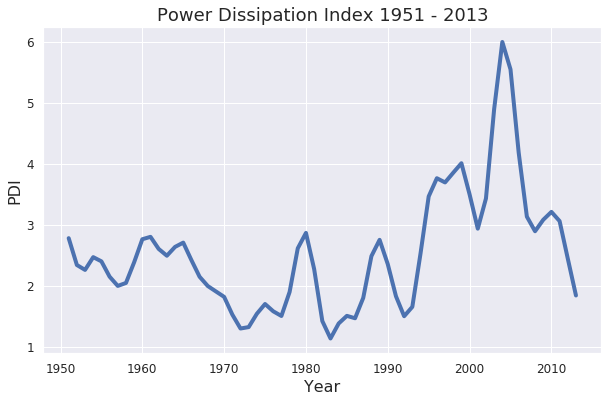

In [5]:
fig,ax = plt.subplots(figsize=(10,6))
plt.title("Power Dissipation Index 1951 - 2013",fontsize = 18)
plt.ylabel("PDI",fontsize = 16)
plt.xlabel("Year",fontsize = 16)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)
plt.plot(PDI.Year,PDI.PDI,lw = 4);

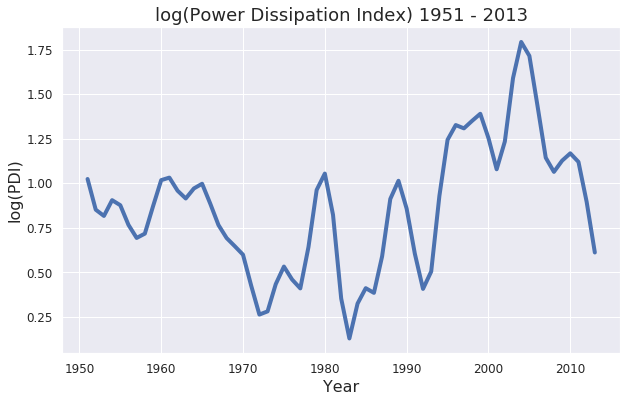

In [6]:
fig,ax = plt.subplots(figsize=(10,6))
plt.title("log(Power Dissipation Index) 1951 - 2013",fontsize = 18)
plt.ylabel("log(PDI)",fontsize = 16)
plt.xlabel("Year",fontsize = 16)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)
plt.plot(PDI.Year,np.log(PDI.PDI),lw = 4);

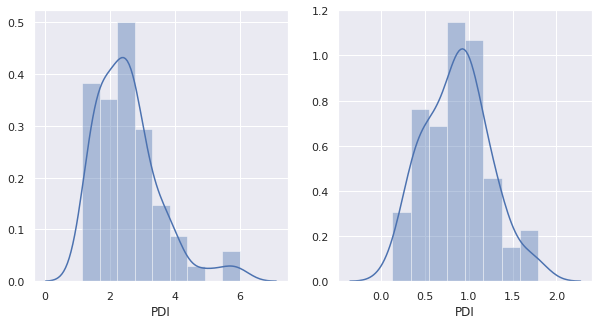

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
sns.distplot(PDI.PDI, ax=axs[0])
sns.distplot(np.log(PDI.PDI), ax=axs[1])

## Atlantic MDR Climate Data

Let's do the same smoothing operation in our "atlantic_mdr" dataset. We're gonna apply a 1–3–4–3–1 weighted average [Emanuel, 2007](ftp://texmex.mit.edu/pub/emanuel/PAPERS/Factors.pdf) on the data, to get out of interannual variability.

In [45]:
atlantic_mdr = pd.read_csv('./Datasets/atlantic_mdr.csv')

def smooth(col):
    n = len(col)
    new_col = np.zeros([n,1])
    w = np.array([[1,3,4,3,1]])
    
    for i in range(2,n-2):
        new_col[i] = w.dot(np.array(col[i-2:i+3]).reshape(-1,1))/12
    return new_col.ravel()

In [48]:
# atlantic_mdr = atlantic_mdr[(atlantic_mdr.Month>=8) & (atlantic_mdr.Month<=10)]
mdr_annual = atlantic_mdr.groupby('Year').agg({'sst':np.mean,
                                               'rhum':np.mean,
                                               'slp':np.mean,
                                               'vwnd':np.mean,'cldc':np.mean})


for col in mdr_annual.columns:
    mdr_annual.loc[:,col] = smooth(mdr_annual[col])
mdr_annual = mdr_annual.loc[1951:2013,:]
mdr_annual

,sst,rhum,slp,vwnd,cldc
Year,,,,,
1951,27.897642,81.564450,1011.181421,-0.690464,4.306995
1952,27.999758,81.676515,1011.280791,-0.645274,4.329181
1953,28.013681,81.473732,1011.249169,-0.608900,4.323822
1954,27.920470,81.129641,1011.109891,-0.659149,4.335832
1955,27.801126,80.978218,1011.019962,-0.745889,4.369884
...,...,...,...,...,...
2009,28.342664,80.619561,1011.120257,-0.805964,4.712272
2010,28.309097,80.761136,1011.076116,-0.857196,4.746834
2011,28.293840,80.914494,1011.047399,-0.916701,4.792242


In [76]:
mdr_annual['PDI'] = np.array(PDI.PDI).reshape(-1,1)
mdr_annual

,sst,rhum,slp,vwnd,cldc,PDI
Year,,,,,,
1951,27.897642,81.564450,1011.181421,-0.690464,4.306995,2.7846
1952,27.999758,81.676515,1011.280791,-0.645274,4.329181,2.3445
1953,28.013681,81.473732,1011.249169,-0.608900,4.323822,2.2639
1954,27.920470,81.129641,1011.109891,-0.659149,4.335832,2.4730
1955,27.801126,80.978218,1011.019962,-0.745889,4.369884,2.4041
...,...,...,...,...,...,...
2009,28.342664,80.619561,1011.120257,-0.805964,4.712272,3.0860
2010,28.309097,80.761136,1011.076116,-0.857196,4.746834,3.2155
2011,28.293840,80.914494,1011.047399,-0.916701,4.792242,3.0646


## Analysing Correlation

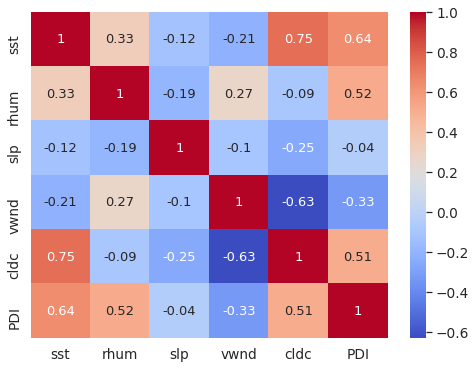

In [79]:

# corr = mdr_annual.corr()
# corr.style.background_gradient(cmap='coolwarm')
f,ax = plt.subplots(1,1,figsize=(8,6))
sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
sns.heatmap(mdr_annual.corr().round(2),
    cmap='coolwarm',annot = True,annot_kws={"size": 13});

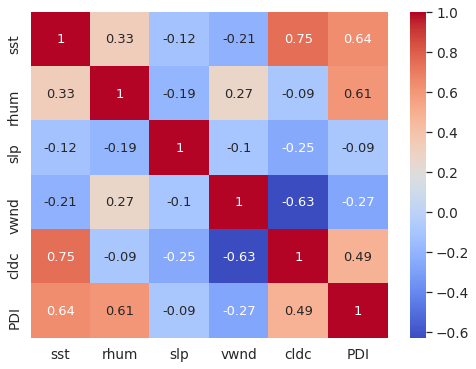

In [80]:
df = mdr_annual
df['PDI'] = np.log(df['PDI'])
# corr = df.corr()
# corr.style.background_gradient(cmap='coolwarm')

f,ax = plt.subplots(1,1,figsize=(8,6))
sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
sns.heatmap(df.corr().round(2),
    cmap='coolwarm',annot = True,annot_kws={"size": 13});

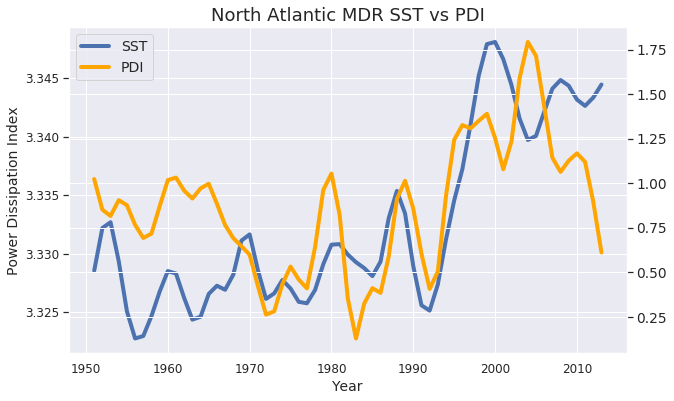

In [81]:
fig,ax = plt.subplots(figsize=(10,6))
plt.title("North Atlantic MDR SST vs PDI",fontsize = 18)

plt.xlabel("Year",fontsize = 14)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)

ax2 = ax.twinx()
ax.plot(np.log(mdr_annual.sst),lw = 4,label = "SST");
ax.set_ylabel("Sea Surface Temperature",fontsize=14)

ax2.plot(mdr_annual.PDI,lw=4,label="PDI",color = 'orange');
ax.set_ylabel("Power Dissipation Index",fontsize=14)


fig.legend(loc="upper left",fontsize=14,bbox_to_anchor=(0,1), bbox_transform=ax.transAxes);

In [18]:
# sns.scatterplot(x=X.sst, y=np.log(mdr_annual['PDI']))
# sns.scatterplot(x=X.sst, y=mdr_annual['PDI'])

## Simple Linear Model

In [82]:
X = mdr_annual.drop(["PDI"],axis=1) 
X = sm.add_constant(X)
# X.sst = np.log(X.sst)
Y = np.log(np.array(mdr_annual['PDI']).reshape(-1,1))
n=len(X)
X_train, X_test = X.iloc[:floor(0.8*n),:],X.iloc[n-floor(0.8*n):,:]
y_train, y_test = Y[:floor(0.8*n)],Y[n-floor(0.8*n):]

# Removido o preditor vwnd por ser ruido:
# model = sm.OLS(y_train, X_train).fit()

model = sm.OLS(y_train, X_train.drop(columns=['vwnd'])).fit()
y_pred = model.predict(X_test.drop(columns=['vwnd'])) 
print(r2_score(y_test,y_pred))
print(model.summary())

0.7357220516420804
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     31.64
Date:                Tue, 25 Aug 2020   Prob (F-statistic):           1.48e-12
Time:                        22:43:33   Log-Likelihood:                -1.6405
No. Observations:                  50   AIC:                             13.28
Df Residuals:                      45   BIC:                             22.84
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -602.4381    217.809 

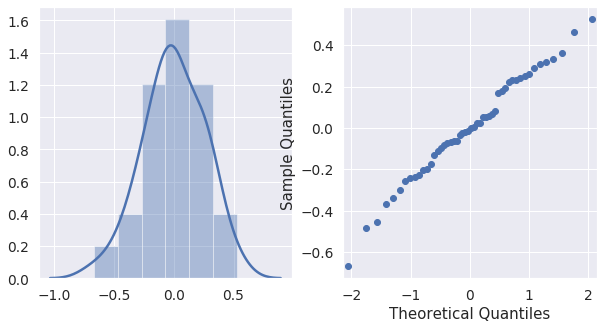

In [83]:
#residuos normais:
fig, axs = plt.subplots(1,2, figsize=[10,5])
sm.qqplot(model.resid, stats.norm, ax=axs[1])
sns.distplot(model.resid, ax=axs[0]) #residuos aproximadamente normais

In [84]:
# df = mdr_annual
# df.PDI = np.log(df.PDI)
# sns.pairplot(df) # o PDI fica mais proximo da gaussiana tirando o log; isso ajuda no ajuste da regressao